<a href="https://colab.research.google.com/github/Ni7070/NumtaDbBanglaDigitRecognizer/blob/main/numtadb_logistic_regression(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import os
from os import path
import shutil
import glob

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tahiranishat","key":"8ed924ff655cd5b32f597aa3e24be0fa"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d BengaliAI/numta

100% 1.90G/1.91G [00:21<00:01, 3.60MB/s]
100% 1.91G/1.91G [00:21<00:00, 93.3MB/s]


In [6]:
from zipfile import ZipFile
file_name = "numta.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done!")

Done!


In [7]:
#read CSV files only filename and digit column
trainA =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainB =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainC =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainD =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainE =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])

In [8]:
print(trainA.columns)
print(trainB.columns)
print(trainC.columns)
print(trainD.columns)
print(trainE.columns)

Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')


In [9]:
percentA = trainA['digit'].value_counts(normalize= True).mul(100).round(1).astype(str) + '%'
percentB = trainB['digit'].value_counts(normalize= True).mul(100).round(1).astype(str) + '%'
percentC = trainC['digit'].value_counts(normalize= True).mul(100).round(1).astype(str) + '%'
percentD = trainD['digit'].value_counts(normalize= True).mul(100).round(1).astype(str) + '%'
percentE = trainE['digit'].value_counts(normalize= True).mul(100).round(1).astype(str) + '%'
print('A:\n',percentA)
print('B:\n',percentB)
print('C:\n',percentC)
print('D:\n',percentD)
print('E:\n',percentE)

A:
 2    10.1%
6    10.1%
4    10.1%
3    10.0%
0    10.0%
5    10.0%
9    10.0%
1    10.0%
7     9.9%
8     9.9%
Name: digit, dtype: object
B:
 2    10.1%
6    10.1%
4    10.1%
3    10.0%
0    10.0%
5    10.0%
9    10.0%
1    10.0%
7     9.9%
8     9.9%
Name: digit, dtype: object
C:
 2    10.1%
6    10.1%
4    10.1%
3    10.0%
0    10.0%
5    10.0%
9    10.0%
1    10.0%
7     9.9%
8     9.9%
Name: digit, dtype: object
D:
 2    10.1%
6    10.1%
4    10.1%
3    10.0%
0    10.0%
5    10.0%
9    10.0%
1    10.0%
7     9.9%
8     9.9%
Name: digit, dtype: object
E:
 2    10.1%
6    10.1%
4    10.1%
3    10.0%
0    10.0%
5    10.0%
9    10.0%
1    10.0%
7     9.9%
8     9.9%
Name: digit, dtype: object


In [10]:
merged_csv = pd.concat(([trainA, trainB, trainC, trainD, trainE]))
print(len(merged_csv))
print(merged_csv.tail())

98510
         filename  digit
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8


In [11]:
TRAIN_PATH = "trainAllNumtadb"
PATH = '/content/'

In [12]:
os.mkdir(TRAIN_PATH)

In [13]:
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)

In [14]:
processImages('training-a')
print('A Done')
processImages('training-b')
print('B Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')
processImages('training-e')
print('E Done')

A Done
B Done
C Done
D Done
E Done


In [15]:
class numtaDb(Dataset):
    def __init__(self, merged_csv_file, root_dir, transform=None):
        self.data = merged_csv_file
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        path = self.root_dir + '/' + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [16]:
mean = [0.5,]
std = [0.5, ]

dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])
'''
LOADING DATASET
'''
dataset = numtaDb(merged_csv_file = merged_csv, root_dir = TRAIN_PATH, 
                            #train=True, 
                            transform = dset_transform # Normalize the image to [0-1] from [0-255]
                            )


In [17]:
#split data into train:test = 90:10
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1)

In [20]:
print(len(train_dataset))
print(len(test_dataset))

88659
9851


Label:
8


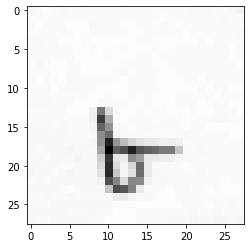

In [21]:
## Displaying another NumtaDb Image
# Label
print("Label:")
print(train_dataset[67][1])

show_img = train_dataset[67][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

###Settings: 01

In [68]:
# Hyperparameters
batch_size = 260
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL 
'''
iteration_loss = []
iter = 0
p = []
l = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)

                pt = predicted.cpu()
                lt = labels.cpu()
                #taking all predicted label into a list
                p.append(pt)
                #taking all real label into a list
                l.append(lt)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

    

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            

Iteration: 500. Loss: 2.294111728668213. Accuracy: 12.7499746218658
Iteration: 1000. Loss: 2.2773730754852295. Accuracy: 18.465130443609787
Iteration: 1500. Loss: 2.267551898956299. Accuracy: 22.251548066186174
Iteration: 2000. Loss: 2.245434522628784. Accuracy: 25.753730585727336
Iteration: 2500. Loss: 2.2444305419921875. Accuracy: 32.78854938584915
Iteration: 3000. Loss: 2.2260379791259766. Accuracy: 33.661557202314484
Iteration: 3500. Loss: 2.2148096561431885. Accuracy: 35.09288397117044
Iteration: 4000. Loss: 2.1977014541625977. Accuracy: 38.46310019287382
Iteration: 4500. Loss: 2.1893815994262695. Accuracy: 39.17368795046188


[2.294111728668213, 2.2773730754852295, 2.267551898956299, 2.245434522628784, 2.2444305419921875, 2.2260379791259766, 2.2148096561431885, 2.1977014541625977, 2.1893815994262695]


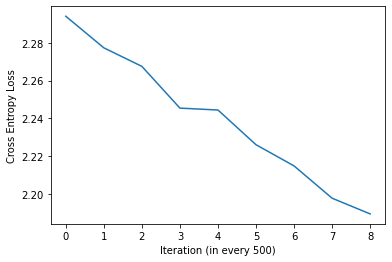

In [69]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

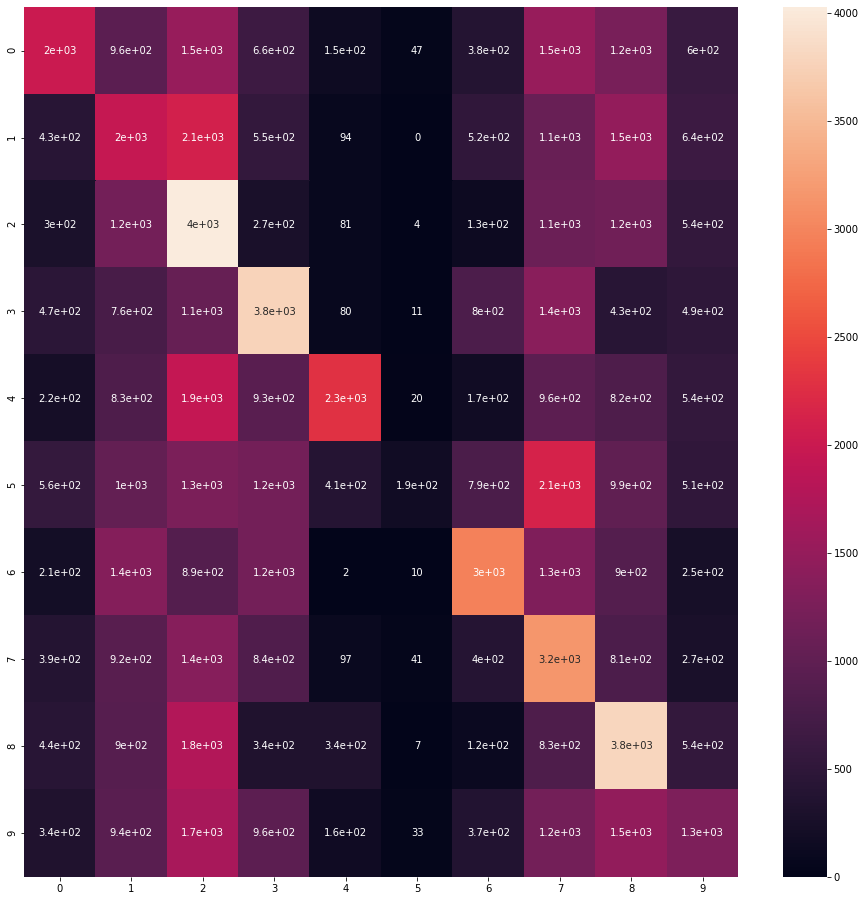

In [70]:
import itertools
import seaborn as sns


#flatten predicted labels and real labels
flatten_l = list(itertools.chain.from_iterable(l))
flatten_p = list(itertools.chain.from_iterable(p))

fig, ax = plt.subplots(figsize=(16, 16))
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(flatten_l, flatten_p)
# print(conf_mat)
sns.heatmap(conf_mat, annot=True)

In [71]:
from sklearn.metrics import classification_report
print(classification_report(flatten_l, flatten_p))

              precision    recall  f1-score   support

           0       0.38      0.22      0.28      9081
           1       0.18      0.22      0.20      8865
           2       0.23      0.46      0.30      8793
           3       0.35      0.41      0.38      9270
           4       0.62      0.26      0.37      8730
           5       0.52      0.02      0.04      9081
           6       0.45      0.33      0.38      9054
           7       0.22      0.38      0.28      8289
           8       0.29      0.42      0.34      9090
           9       0.23      0.15      0.18      8406

    accuracy                           0.29     88659
   macro avg       0.35      0.29      0.27     88659
weighted avg       0.35      0.29      0.28     88659



In [72]:
#colab mount
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [73]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/pickle Files/"
save_model = True
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'numtadbLR1.pkl') 

In [74]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'numtadbLR1.pkl'))

Settings: 02

In [88]:
# Hyperparameters 
batch_size = 260
num_iters = 4000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL 
'''
iteration_loss = []
iter = 0
p = []
l = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)

                pt = predicted.cpu()
                lt = labels.cpu()
                #taking all predicted label into a list
                p.append(pt)
                #taking all real label into a list
                l.append(lt)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

    

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.0212326049804688. Accuracy: 41.71150137041925
Iteration: 1000. Loss: 1.898637056350708. Accuracy: 46.64501065881636
Iteration: 1500. Loss: 1.872126817703247. Accuracy: 51.52776367881433
Iteration: 2000. Loss: 1.8233057260513306. Accuracy: 50.87808344330525
Iteration: 2500. Loss: 1.762062907218933. Accuracy: 50.64460460866917
Iteration: 3000. Loss: 1.7670313119888306. Accuracy: 49.9644706121206
Iteration: 3500. Loss: 1.7613389492034912. Accuracy: 53.11135925286773


[2.0212326049804688, 1.898637056350708, 1.872126817703247, 1.8233057260513306, 1.762062907218933, 1.7670313119888306, 1.7613389492034912]


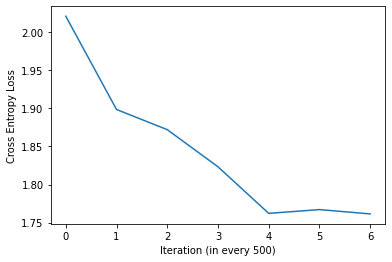

In [89]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

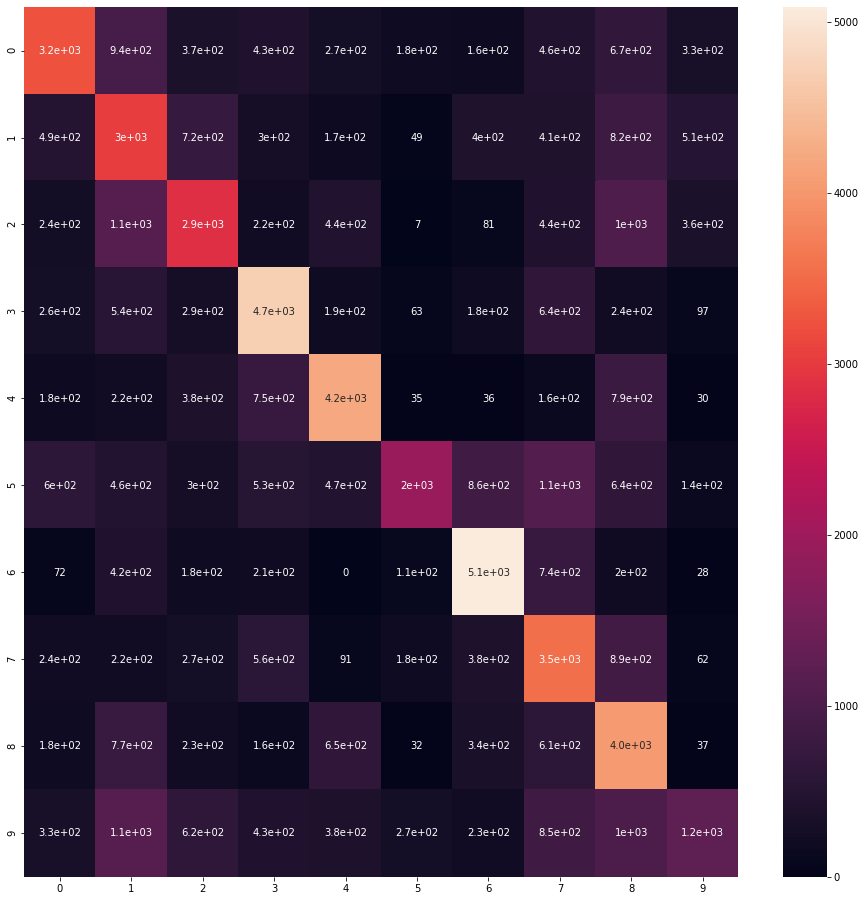

In [92]:
import itertools
import seaborn as sns


#flatten predicted labels and real labels
flatten_l = list(itertools.chain.from_iterable(l))
flatten_p = list(itertools.chain.from_iterable(p))

fig, ax = plt.subplots(figsize=(16, 16))
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(flatten_l, flatten_p)
# print(conf_mat)
sns.heatmap(conf_mat, annot=True)

In [93]:
print(classification_report(flatten_l, flatten_p))

              precision    recall  f1-score   support

           0       0.56      0.46      0.50      7063
           1       0.34      0.44      0.38      6895
           2       0.46      0.42      0.44      6839
           3       0.57      0.65      0.61      7210
           4       0.61      0.62      0.62      6790
           5       0.68      0.28      0.39      7063
           6       0.65      0.72      0.69      7042
           7       0.40      0.55      0.46      6447
           8       0.39      0.57      0.46      7070
           9       0.44      0.19      0.27      6538

    accuracy                           0.49     68957
   macro avg       0.51      0.49      0.48     68957
weighted avg       0.51      0.49      0.48     68957



In [94]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/pickle Files/"
save_model = True
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'numtadbLR2.pkl') 

Settings: 03

In [95]:
# Hyperparameters 
batch_size = 168
num_iters = 7000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL 
'''
iteration_loss = []
iter = 0
p = []
l = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)

                pt = predicted.cpu()
                lt = labels.cpu()
                #taking all predicted label into a list
                p.append(pt)
                #taking all real label into a list
                l.append(lt)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

    

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.607854962348938. Accuracy: 48.23875748654959
Iteration: 1000. Loss: 1.6571741104125977. Accuracy: 53.903157039894424
Iteration: 1500. Loss: 1.3952372074127197. Accuracy: 58.22759110750177
Iteration: 2000. Loss: 1.3968442678451538. Accuracy: 60.257841843467666
Iteration: 2500. Loss: 1.3115818500518799. Accuracy: 63.48594051365344
Iteration: 3000. Loss: 1.1043846607208252. Accuracy: 59.394985280682164
Iteration: 3500. Loss: 1.3125090599060059. Accuracy: 63.688965587250024
Iteration: 4000. Loss: 1.1980375051498413. Accuracy: 60.80600954217846
Iteration: 4500. Loss: 1.3261512517929077. Accuracy: 59.49649781748046
Iteration: 5000. Loss: 1.015012502670288. Accuracy: 59.12090143132677
Iteration: 5500. Loss: 1.1725058555603027. Accuracy: 56.38006293777281
Iteration: 6000. Loss: 1.1251802444458008. Accuracy: 65.36392244442189
Iteration: 6500. Loss: 1.1035006046295166. Accuracy: 62.31854634047305


[1.607854962348938, 1.6571741104125977, 1.3952372074127197, 1.3968442678451538, 1.3115818500518799, 1.1043846607208252, 1.3125090599060059, 1.1980375051498413, 1.3261512517929077, 1.015012502670288, 1.1725058555603027, 1.1251802444458008, 1.1035006046295166]


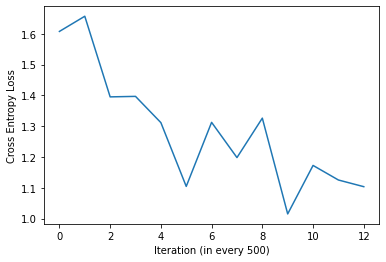

In [96]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

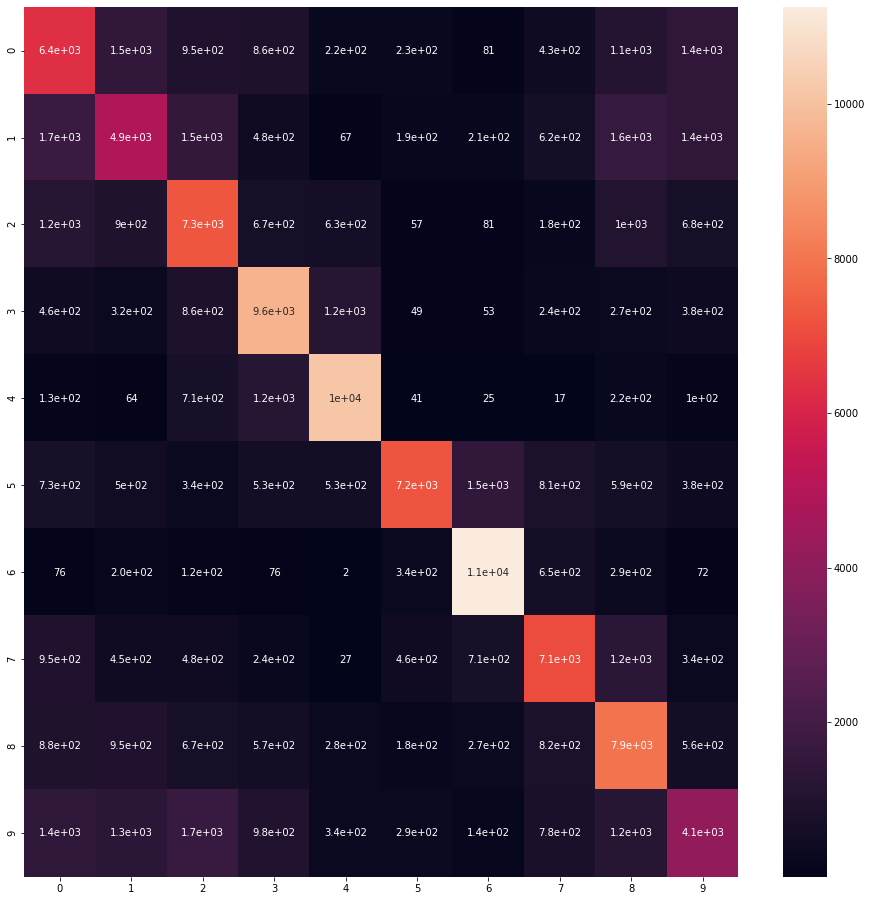

In [97]:
import itertools
import seaborn as sns


#flatten predicted labels and real labels
flatten_l = list(itertools.chain.from_iterable(l))
flatten_p = list(itertools.chain.from_iterable(p))

fig, ax = plt.subplots(figsize=(16, 16))
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(flatten_l, flatten_p)
# print(conf_mat)
sns.heatmap(conf_mat, annot=True)

In [98]:
print(classification_report(flatten_l, flatten_p))

              precision    recall  f1-score   support

           0       0.46      0.48      0.47     13117
           1       0.45      0.38      0.41     12805
           2       0.50      0.57      0.53     12701
           3       0.63      0.72      0.67     13390
           4       0.76      0.80      0.78     12610
           5       0.80      0.55      0.65     13117
           6       0.79      0.86      0.82     13078
           7       0.61      0.59      0.60     11973
           8       0.51      0.60      0.56     13130
           9       0.43      0.34      0.38     12142

    accuracy                           0.59    128063
   macro avg       0.59      0.59      0.59    128063
weighted avg       0.59      0.59      0.59    128063



In [99]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/pickle Files/"
save_model = True
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'numtadbLR3.pkl') 

# **ID: 16.02.04.070**
# **Assignment #2**
# **Problem #1**
# **new**


No.|batch_size | num_iters | learning rate|optimizer|Accuracy
---|---|---|---|---|---|
1|260|5,000|0.001|SGD|29%
2|250|4,000|0.01|Adagrad|49%
3|168|7,000|0.01|Adam|59%
